In [1]:
from importlib import reload
from rlxutils import subplots
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

import omegaconf
from loguru import logger
from omegaconf import DictConfig, OmegaConf
import hydra
from progressbar import progressbar as pbar

from earthtext.datamodules import chipmultilabel

from importlib import reload
reload(chipmultilabel)

<module 'earthtext.datamodules.chipmultilabel' from '/home/ubuntu/earth-text/src/earthtext/datamodules/chipmultilabel.py'>

In [3]:
conf = OmegaConf.load("../../configs/multilabel.yaml")
dl = hydra.utils.instantiate(conf.dataloader)

2024-04-12 01:04:59.660 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:76 - checking chip files for train split
100% (60396 of 60396) |##################| Elapsed Time: 0:00:03 Time:  0:00:030000
2024-04-12 01:05:03.166 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:80 - read train split with 60295 chip files (out of 60396)
2024-04-12 01:05:03.167 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:82 - max cache size is -1
2024-04-12 01:05:03.868 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:76 - checking chip files for val split
100% (12304 of 12304) |##################| Elapsed Time: 0:00:00 Time:  0:00:000000
2024-04-12 01:05:04.573 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:80 - read val split with 12288 chip files (out of 12304)
2024-04-12 01:05:04.573 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:82 - max cache size is -1
2024-04-12 01:05:05.

In [4]:
dltrain = dl.train_dataloader()

m = hydra.utils.instantiate(conf.model)

optimizer = torch.optim.Adam(m.parameters(), lr=1e-5)

sum([np.product(p.shape) for p in m.parameters()])

570723

In [6]:
n_epochs = 100

lossh = []
for epoch in range(n_epochs):
    for step, batch in enumerate(dltrain):
        # extract data from batch
        x = batch['embedding']
        t = batch['multilabel']

        # run model
        o = m(x)

        # compute losses (complex mse or rmse)
        loss = - torch.mean(torch.log(o + 1e-5)*t + torch.log(1-o + 1e-5)*(1-t))
        
        # backpropage and update
        loss.backward()
        optimizer.step()
        
        # cosmetics
        lossn = loss.detach().cpu().numpy()
        lossh.append(lossn)
        psummary = np.mean([(p.abs().mean().detach().cpu().numpy()) for p in m.parameters()])    
        lossm = np.mean(lossh[-50:])
        print(f"epoch {epoch:3} step {step:3d} loss {lossm:.5f} params {psummary:.7f}", end="\r")
        
    print()

epoch   0 step 3768 loss 0.18394 params 0.0372818
epoch   1 step 3768 loss 0.14985 params 0.0555286
epoch   2 step 3768 loss 0.15518 params 0.0798154
epoch   3 step 3768 loss 0.16332 params 0.1027357
epoch   4 step 3768 loss 0.15159 params 0.1264806
epoch   5 step 3768 loss 0.14882 params 0.1511634
epoch   6 step 3768 loss 0.14922 params 0.1770982
epoch   7 step 3768 loss 0.13214 params 0.2039165
epoch   8 step 3768 loss 0.13960 params 0.2306977
epoch   9 step 3768 loss 0.13575 params 0.2575920
epoch  10 step 3768 loss 0.14047 params 0.2846227
epoch  11 step 3768 loss 0.13966 params 0.3116568
epoch  12 step 3768 loss 0.14190 params 0.3387696
epoch  13 step 3768 loss 0.14044 params 0.3660841
epoch  14 step 3768 loss 0.13739 params 0.3932623
epoch  15 step 3768 loss 0.13111 params 0.4204695
epoch  16 step 3768 loss 0.13542 params 0.4475818
epoch  17 step 3768 loss 0.13403 params 0.4743849
epoch  18 step 3768 loss 0.13267 params 0.5009120
epoch  19 step 3768 loss 0.13165 params 0.5272161


Text(0, 0.5, 'loss')

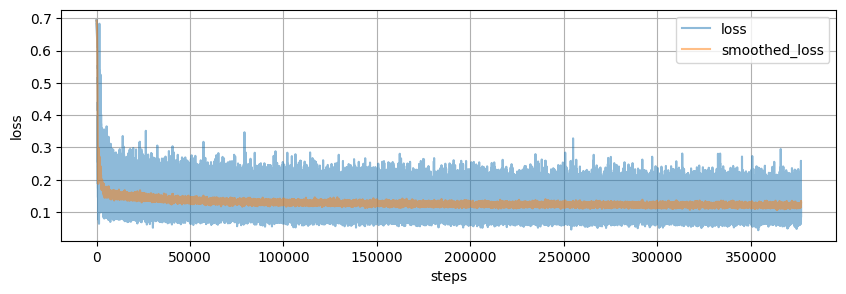

In [7]:
lossp = pd.DataFrame(lossh, columns=['loss'])
lossp['smoothed_loss'] = lossp.loss.rolling(50).mean()
lossp.plot(alpha=.5, figsize=(10,3))
plt.grid(); plt.xlabel("steps"); plt.ylabel("loss")

In [8]:
targets = []
predictions = []
dltrain = dl.train_dataloader()
for batch in pbar(dltrain):
    x = batch['embedding']
    t = batch['multilabel']

    o = m(x)

    for ti in t.detach().numpy():
        targets.append(ti)

    for oi in o.detach().numpy():
        predictions.append(oi)
    
targets = np.r_[targets]
predictions = np.r_[predictions]
targets.shape, predictions.shape

100% (3769 of 3769) |####################| Elapsed Time: 0:00:13 Time:  0:00:130001


((60295, 99), (60295, 99))

In [9]:
idxs = np.random.permutation(len(targets))[:300]

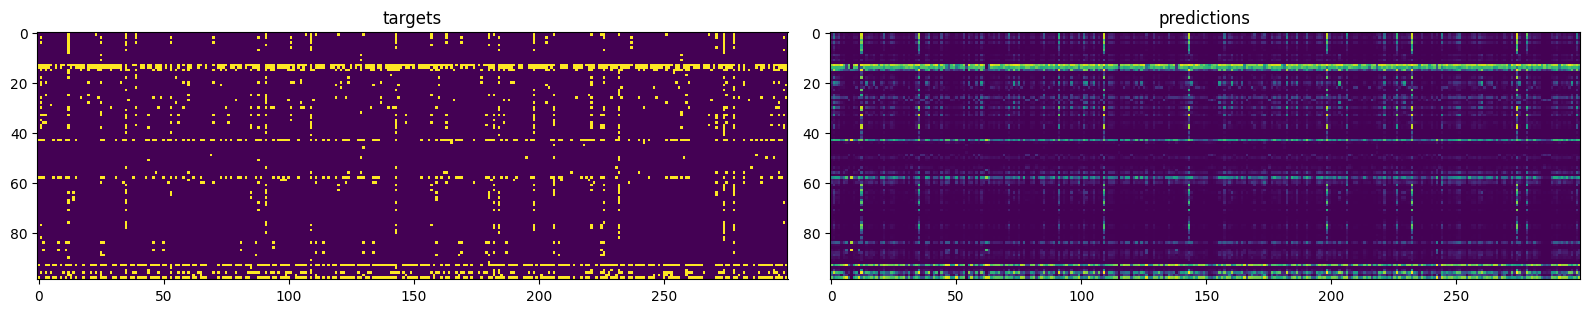

In [10]:
for ax, i in subplots(2, usizex=8):
    if i==0: 
        plt.imshow(targets[idxs].T, interpolation='none')
        plt.title("targets")
    if i==1:
        plt.imshow(predictions[idxs].T, interpolation='none', vmin=0, vmax=1)
        plt.title("predictions")
        #plt.colorbar();

In [11]:
from sklearn.metrics import precision_score, recall_score

tpr = lambda y_true, y_pred: np.mean(y_true[y_true==1] == y_pred[y_true==1])
tnr = lambda y_true, y_pred: np.mean(y_true[y_true==0] == y_pred[y_true==0])
prec = lambda y_true, y_pred: sum(y_true[y_pred==1]) / sum(y_pred==1) if sum(y_pred==1)>0 else None

acc = lambda y_true, y_pred: np.mean(y_true==y_pred)

metr = lambda y_true, y_pred: {'tpr': tpr(y_true, y_pred), 'tnr': tnr(y_true, y_pred), 'acc': acc(y_true, y_pred), 'prec': prec(y_true, y_pred)}

In [12]:
metr(targets.flatten(), predictions.flatten()>.5)

{'tpr': 0.5767012011351924,
 'tnr': 0.9821519242111034,
 'acc': 0.9543408209300903,
 'prec': 0.7041051529853083}

In [13]:
precision_score(targets.flatten(), predictions.flatten()>.5), \
recall_score(targets.flatten(), predictions.flatten()>.5)


(0.7041051529853083, 0.5767012011351924)

In [14]:
r = [metr(targets[:,c], predictions[:,c]>.5) for c in range(targets.shape[-1])]    
r = pd.DataFrame(r)

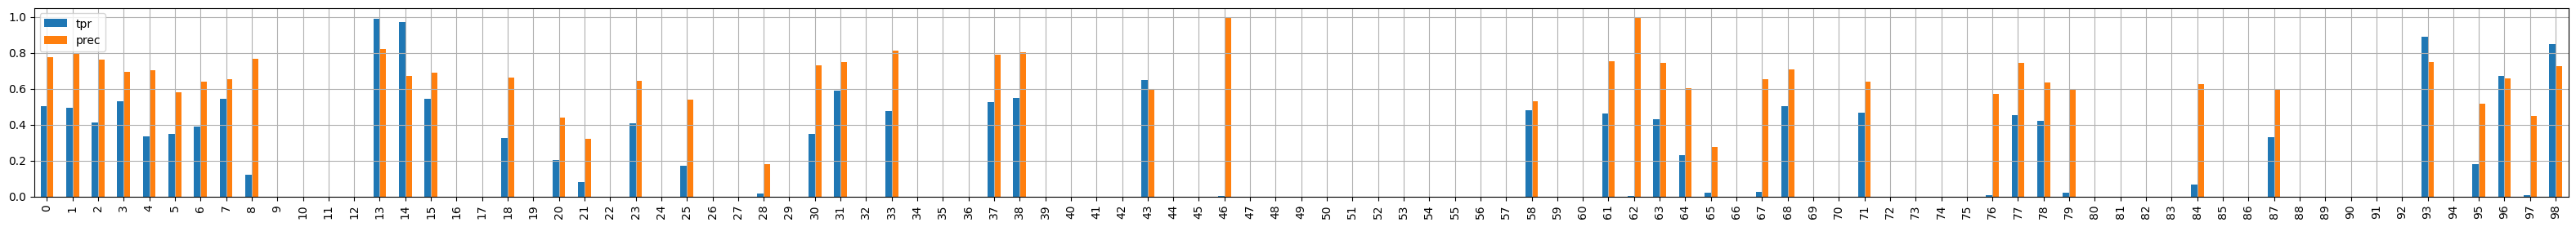

In [15]:
r[['tpr', 'prec']].plot(kind='bar', figsize=(40,3))
plt.grid()